In [48]:
import pandas as pd
from google.cloud import bigquery
import numpy as np
import matplotlib.pyplot as plt
import ast

In [49]:
not_in_new_df = pd.read_csv('output/papers_not_in_new.csv', index_col=0)

In [ ]:
point_per_reason = True

output_name = "output/excluded_counts.xlsx"

def safe_literal_eval(s):
    if isinstance(s, str):
        try:
            return ast.literal_eval(s)
        except (ValueError, SyntaxError):
            return []
    return s

if not point_per_reason:
    not_in_new_df['exclusion_reason'] = not_in_new_df['exclusion_reason'].apply(safe_literal_eval)
    output_name = "output/excluded_counts_multiple_reasons.xlsx"

exclusion_reasons_df = not_in_new_df.explode('exclusion_reason')

exclusion_reasons_df = exclusion_reasons_df.groupby(['company_name', 'exclusion_reason']).size().reset_index(name='count')

exclusion_reasons_df

,company_name,exclusion_reason,count
0,ABN AMRO,['no_publication_date'],3
1,ANZ,['no_publication_date'],1
2,BBVA,['excluded_tags'],1
3,BBVA,['no_publication_date'],2
4,BBVA,['no_tags'],6
...,...,...,...
103,Wells Fargo,['excluded_tags'],4
104,Wells Fargo,['no_publication_date'],7
105,Wells Fargo,"['no_tags', 'no_authors', 'no_publication_date']",1
106,Wells Fargo,['no_tags'],2


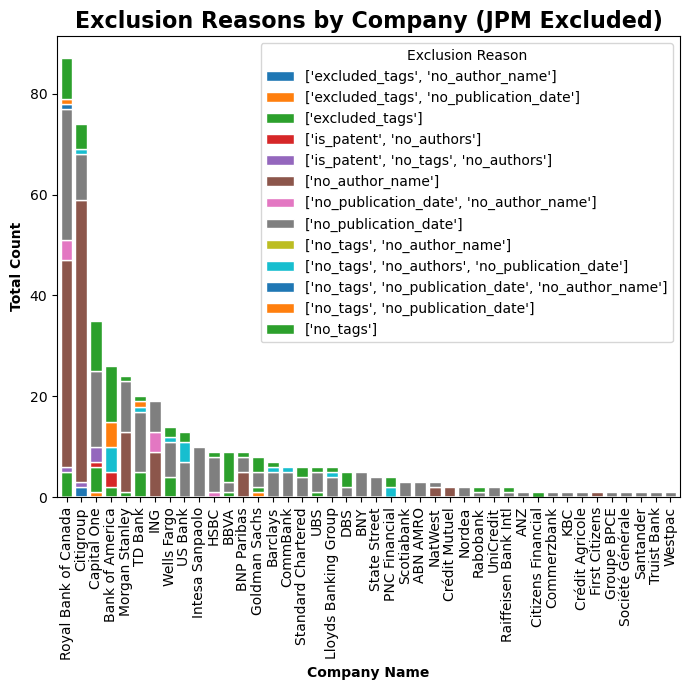

In [54]:
pivoted_df = exclusion_reasons_df.pivot(
    index='company_name',
    columns='exclusion_reason',
    values='count'
).fillna(0)

pivoted_df['total'] = pivoted_df.sum(axis=1)

pivoted_df.sort_values(by='total', ascending=False,inplace=True)

graph_title = "Exclusion Reasons by Company"

JPM_excluded = True

if JPM_excluded:
    pivoted_df.drop("JPMorganChase", inplace=True)
    graph_title = "Exclusion Reasons by Company (JPM Excluded)"

ax = pivoted_df.drop(columns="total").plot(
    kind='bar',
    stacked=True,
    figsize=(7, 7),
    edgecolor='white',
    width=0.8   
)

plt.title(graph_title, fontsize=16, fontweight='bold')
plt.xlabel('Company Name', fontweight='bold')
plt.ylabel('Total Count', fontweight='bold')
plt.legend(title='Exclusion Reason')
plt.tight_layout()
plt.show()

In [ ]:
# pivoted_df.to_excel(output_name)